##  추출 요약 (Extractive)
- 원문에서 요약할 문장을 추출하여 요약하는 방법  : koBERT의 max_len = 512
- **데이터 형태** : 추출될 토큰과 추출되지 않을 토큰에 대해 1과 0으로 라벨링하여 학습 

{
  "input_ids": [2, 1618, 7344, 6705, 2132, 5476, 5468, 6116, 1652, 4930, 5030, 6493,...],

  "token_type_ids": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...],

  "attention_mask": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],

  "labels": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]
}

- **모델 학습 방법** : NER에서 토큰별 라벨을 분류하는 방법과 같이 추출될 문장1과 추출되지 않을 문장0으로 나누어 학습시킴 

In [ ]:
#!pip install kobert_transformers
#!pip install transformers

In [5]:
import torch
import torch.nn as nn
import math
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import BertPreTrainedModel
from kobert_transformers import get_kobert_model
#from model.config import get_kobert_config

In [6]:
### extraction 
class KoBERTforExtractiveSummarization(BertPreTrainedModel):
  def __init__(self,
                num_labels = 2,
                hidden_size = 768,
                hidden_dropout_prob = 0.1,
               ):
    super().__init__(get_kobert_config())

    self.num_labels = num_labels
    self.kobert = get_kobert_model()
    self.dropout = nn.Dropout(hidden_dropout_prob)
    self.ffn = nn.Linear(hidden_size, 4*hidden_size)
    self.classifier = nn.Linear(4*hidden_size, num_labels)

    self.init_weights()

  def forward(
          self,
          input_ids=None,
          attention_mask=None,
          token_type_ids=None,
          position_ids=None,
          head_mask=None,
          inputs_embeds=None,
          labels=None
  ):
    outputs = self.kobert(
      input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids,
      position_ids=position_ids,
      head_mask=head_mask,
      inputs_embeds=inputs_embeds,
    )

    sequence_output = outputs[0]

    sequence_output = self.dropout(sequence_output)
    sequence_output = self.ffn(sequence_output)
    logits = self.classifier(sequence_output)

    loss = None
    if labels is not None:
      loss_fct = CrossEntropyLoss()#reduction='sum') # reduction mean makes loss small
      # Only keep active parts of the loss
      if attention_mask is not None:
        active_loss = attention_mask.view(-1) == 1
        active_logits = logits.view(-1, self.num_labels)
        active_labels = torch.where(
          active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
        )
        loss = loss_fct(active_logits, active_labels)
      else:
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

    return_data ={
      'loss':loss,
      'logits':logits
    }
    return return_data # (loss), logits, (hidden_states), (attentions)

In [7]:
## output classification 
class KoBERTforSequenceClassfication(BertPreTrainedModel):
  def __init__(self,
                num_labels = 2,
                hidden_size = 768,
                hidden_dropout_prob = 0.1,
               ):
    super().__init__(get_kobert_config())

    self.num_labels = num_labels
    self.kobert = get_kobert_model()
    self.dropout = nn.Dropout(hidden_dropout_prob)
    self.ffn = nn.Linear(hidden_size, 4*hidden_size)
    self.classifier = nn.Linear(4*hidden_size, num_labels)

    self.init_weights()

  def forward(
          self,
          input_ids=None,
          attention_mask=None,
          token_type_ids=None,
          position_ids=None,
          head_mask=None,
          inputs_embeds=None,
          labels=None,
  ):
    outputs = self.kobert(
      input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids,
      position_ids=position_ids,
      head_mask=head_mask,
      inputs_embeds=inputs_embeds,
    )

    pooled_output = outputs[1]

    pooled_output = self.dropout(pooled_output)
    ffn_output = self.ffn(pooled_output)
    logits = self.classifier(ffn_output)

    outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

    if labels is not None:
      if self.num_labels == 1:
        #  We are doing regression
        loss_fct = MSELoss()
        loss = loss_fct(logits.view(-1), labels.view(-1))
      else:
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
      outputs = (loss,) + outputs

    return outputs  # (loss), logits, (hidden_states), (attentions)

In [8]:
### to make input shape of ko-bert 
def kobert_input(tokenizer, str, device = None, max_seq_len = 512):
  index_of_words = tokenizer.encode(str)
  token_type_ids = [0] * len(index_of_words)
  attention_mask = [1] * len(index_of_words)

  # Padding Length
  padding_length = max_seq_len - len(index_of_words)

  # Zero Padding
  index_of_words += [0] * padding_length
  token_type_ids += [0] * padding_length
  attention_mask += [0] * padding_length

  data = {
    'input_ids': torch.tensor([index_of_words]).to(device),
    'token_type_ids': torch.tensor([token_type_ids]).to(device),
    'attention_mask': torch.tensor([attention_mask]).to(device),
  }
  return data

In [10]:
## for logging
import logging

from transformers.configuration_utils import PretrainedConfig
from transformers import BertModel, BertConfig

In [11]:
logger = logging.getLogger(__name__)

#KoBERT
kobert_config = {
    'attention_probs_dropout_prob': 0.1,
    'hidden_act': 'gelu',
    'hidden_dropout_prob': 0.1,
    'hidden_size': 768,
    'initializer_range': 0.02,
    'intermediate_size': 3072,
    'max_position_embeddings': 512,
    'num_attention_heads': 12,
    'num_hidden_layers': 12,
    'type_vocab_size': 2,
    'vocab_size': 8002
}

In [12]:
def get_kobert_config():
    return BertConfig.from_dict(kobert_config)

### for dataset

In [22]:
def jsonl_load(data_path = './data/train.jsonl'):
  data = []
  with open(data_path, 'r') as json_file:
      json_list = list(json_file)

  for json_str in json_list:
      data.append(json.loads(json_str))

  return data

In [23]:
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset
from kobert_transformers import get_tokenizer

In [24]:
class ExtractiveDataset(Dataset):
  def __init__(self,
               data_path= './data/train.jsonl',
               num_label = 2, # 추출할것과 추출하지 않을 것들로
               device = 'cpu',
               max_seq_len = 512, # KoBERT max_length
               ):
    self.device = device
    self.data =[]
    self.tokenizer = get_tokenizer()

    cls_token_id = self.tokenizer.cls_token_id # [CLS]
    sep_token_id = self.tokenizer.sep_token_id # [SEP]
    pad_token_id = self.tokenizer.pad_token_id # [PAD]

    jsonl_datas = jsonl_load(data_path=data_path)
    # for dict_data in jsonl_datas:
    for dict_data in tqdm(jsonl_datas):
      articles = dict_data['article_original']
      extractive_indices = dict_data['extractive']

      index_of_words = None
      token_type_ids = None
      label= None
      token_num = None

      token_type_state = False

      for idx in range(len(articles)):
        label_state = True if idx in extractive_indices else False

        if idx == 0: # 맨 처음 문장인 경우
          index_of_words = [cls_token_id]
          token_type_ids = [int(token_type_state)]
          label = [int(label_state)]
          token_num = 1

        article = articles[idx]
        tmp_index = self.tokenizer.encode(article, add_special_tokens=False)
        num_tmp_index = len(tmp_index) + 1

        if token_num +  num_tmp_index <= max_seq_len:
          index_of_words += tmp_index + [sep_token_id]
          token_type_ids += [int(token_type_state)] * num_tmp_index

          label += [int(label_state)] * num_tmp_index
          token_num += num_tmp_index
          token_type_state = not token_type_state

        if token_num +  num_tmp_index > max_seq_len or idx == len(articles)-1 :
          # attention mask
          attention_mask = [1] * token_num

          # Padding Length
          padding_length = max_seq_len - token_num

          # Padding
          index_of_words += [pad_token_id] * padding_length # [PAD] padding
          token_type_ids += [token_type_state] * padding_length # last token_type_state padding
          attention_mask += [0] * padding_length # zero padding

          # Label Zero Padding
          label += [0] * padding_length

          # Data Append
          data = {
                  'input_ids': torch.tensor(index_of_words).to(self.device),
                  'token_type_ids': torch.tensor(token_type_ids).to(self.device),
                  'attention_mask': torch.tensor(attention_mask).to(self.device),
                  'labels': torch.tensor(label).to(self.device)
                 }
          self.data.append(data)

          # Data Initialization
          index_of_words = [cls_token_id]
          token_type_ids = [int(token_type_state)]
          label = [int(label_state)]
          token_num = 1
          token_type_state = False


  def __len__(self):
    return len(self.data)
  def __getitem__(self,index):
    item = self.data[index]
    return item

### train extractive model 

In [ ]:
#!pip install dataset

In [25]:
## req
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from tqdm import tqdm

import torch
from transformers import AdamW
from torch.utils.data import dataloader

In [30]:
import json

Train(4): 100%|██████████| 8/8 [01:39<00:00, 12.40s/it, Loss: 1.139 (0.651)]


,loss
0,1.169115
1,0.865778
2,0.678248
3,0.661203
4,0.651073


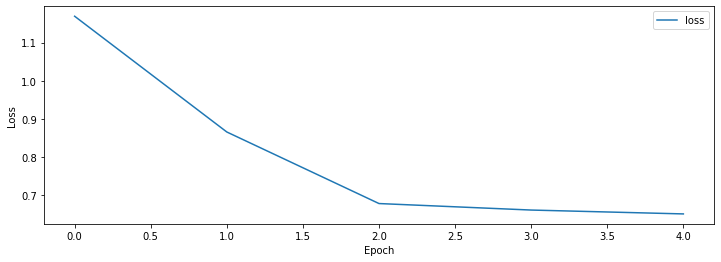

In [32]:
def train(epoch, model, optimizer, train_loader, save_step, save_ckpt_path, train_step = 0):
    losses = []
    train_start_index = train_step+1 if train_step != 0 else 0
    total_train_step = len(train_loader)
    model.train()

    with tqdm(total= total_train_step, desc=f"Train({epoch})") as pbar:
        pbar.update(train_step)
        for i, data in enumerate(train_loader, train_start_index):

            optimizer.zero_grad()
            outputs = model(**data)

            loss = outputs['loss']
            losses.append(loss.item())

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss.item():.3f} ({np.mean(losses):.3f})")

            if i >= total_train_step or i % save_step == 0:
                torch.save({
                    'epoch': epoch,  # 현재 학습 epoch
                    'model_state_dict': model.state_dict(),  # 모델 저장
                    'optimizer_state_dict': optimizer.state_dict(),  # 옵티마이저 저장
                    'loss': loss.item(),  # Loss 저장
                    'losses':losses,
                    'train_step': i,  # 현재 진행한 학습
                    'total_train_step': len(train_loader)  # 현재 epoch에 학습 할 총 train step
                }, save_ckpt_path)

    return np.mean(losses)



if __name__ == '__main__':
    checkpoint_path ="./checkpoint"
    save_ckpt_path = f"{checkpoint_path}/kobert-extractive.pth"

    n_epoch = 5          # Num of Epoch
    batch_size = 2      # 배치 사이즈
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_step = 100 # 학습 저장 주기
    learning_rate = 5e-5  # Learning Rate

    # WellnessTextClassificationDataset 데이터 로더
    dataset = ExtractiveDataset(data_path='./data/train_test.jsonl', device=device)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = KoBERTforExtractiveSummarization()
    model.to(device)

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

    pre_epoch, pre_loss, train_step = 0, 0, 0
    losses = []

    # if os.path.isfile(save_ckpt_path):
    #     checkpoint = torch.load(save_ckpt_path, map_location=device)
    #     pre_epoch = checkpoint['epoch']
    #     pre_loss = checkpoint['loss']
    #     losses = checkpoint['losses']
    #     train_step =  checkpoint['train_step']
    #     total_train_step =  checkpoint['total_train_step']
    #
    #     model.load_state_dict(checkpoint['model_state_dict'])
    #     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #
    #     print(f"load pretrain from: {save_ckpt_path}, epoch={pre_epoch}, loss={pre_loss}")
    #     # best_epoch += 1

    offset = pre_epoch
    for step in range(n_epoch):
        epoch = step + offset
        loss = train(epoch, model, optimizer, train_loader, save_step, save_ckpt_path, train_step)
        losses.append(loss)

    # data
    data = {
        "loss": losses
    }
    df = pd.DataFrame(data)
    display(df)

    # graph
    plt.figure(figsize=[12, 4])
    plt.plot(losses, label="loss")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

### run extractive model 
- submisstion : id(아이디명), summary(추출 요약문)

In [33]:
# req
import csv
import torch
from tqdm import tqdm

from kobert_transformers import get_tokenizer

In [34]:
### for eval dataset
class ExtractiveDataset(Dataset):
  def __init__(self,
               tokenizer,
               device = 'cpu',
               data_path='./data/extractive_test_v2.jsonl',
               max_seq_len = 512, # KoBERT max_length
               ):
    self.device = device
    self.data =[]
    self.tokenizer = tokenizer

    cls_token_id = self.tokenizer.cls_token_id # [CLS]
    sep_token_id = self.tokenizer.sep_token_id # [SEP]
    pad_token_id = self.tokenizer.pad_token_id # [PAD]

    jsonl_datas = jsonl_load(data_path = data_path)
    for dict_data in tqdm(jsonl_datas):
      id = dict_data["id"]
      articles = dict_data['article_original']

      index_of_words = None
      token_type_ids = None
      token_num = None

      token_type_state = False

      for idx in range(len(articles)):

        if idx == 0: # 맨 처음 문장인 경우
          index_of_words = [cls_token_id]
          token_type_ids = [int(token_type_state)]
          token_num = 1

        article = articles[idx]
        tmp_index = self.tokenizer.encode(article, add_special_tokens=False)
        num_tmp_index = len(tmp_index) + 1

        if token_num +  num_tmp_index <= max_seq_len:
          index_of_words += tmp_index + [sep_token_id]
          token_type_ids += [int(token_type_state)] * num_tmp_index

          token_num += num_tmp_index
          token_type_state = not token_type_state

        if token_num +  num_tmp_index > max_seq_len or idx == len(articles)-1 :
          # attention mask
          attention_mask = [1] * token_num

          # Padding Length
          padding_length = max_seq_len - token_num

          # Padding
          index_of_words += [pad_token_id] * padding_length # [PAD] padding
          token_type_ids += [token_type_state] * padding_length # last token_type_state padding
          attention_mask += [0] * padding_length # zero padding

          # Data Append
          # Need additional 1 dimension for inference
          input = {
                  'input_ids': torch.tensor([index_of_words]).to(self.device),
                  'token_type_ids': torch.tensor([token_type_ids]).to(self.device),
                  'attention_mask': torch.tensor([attention_mask]).to(self.device),
                 }
          self.data.append({
            "id":id,
            "input":input
          })

          # Data Initialization
          index_of_words = [cls_token_id]
          token_type_ids = [int(token_type_state)]
          token_num = 1
          token_type_state = False


  def __len__(self):
    return len(self.data)
  def __getitem__(self,index):
    item = self.data[index]
    return item

In [35]:
# config
tokenizer = get_tokenizer()
dir_path="."
ckpt_path = f'{dir_path}/checkpoint/kobert-extractive.pth'
csv_path = f'{dir_path}/data/extractive_summary_kobert.csv'
ctx = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(ctx)

In [36]:
# load data
eval_datas = ExtractiveDataset(tokenizer=tokenizer,data_path='./data/eval_test.jsonl')

100%|██████████| 9/9 [00:00<00:00, 217.08it/s]


In [37]:
# load kobert checkpoint
checkpoint = torch.load(ckpt_path, map_location=device)
model = KoBERTforExtractiveSummarization()
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [38]:
# eval csv_path
# 한글 깨짐 방지 설정 encoding='utf-8-sig'
f = open(csv_path, 'w', encoding='utf-8-sig', newline='')
wr = csv.writer(f)
wr.writerow(['id','summary'])

12

In [39]:
result_data = {}
for data in tqdm(eval_datas):
  id = data['id']
  input = data['input']

  output = model(**input)
  logit = output['logits'][0]
  softmax_logit = torch.softmax(logit, dim=1)
  argmax = torch.argmax(softmax_logit, dim=1)


  extractive_index = torch.nonzero(argmax.bool()).view(-1)
  extractive_input_ids = torch.index_select(input=input['input_ids'],index=extractive_index,dim=-1)
  result = tokenizer.decode(extractive_input_ids.squeeze(),skip_special_tokens=True)
  print(result)

  if id in result_data.keys():
    result_data[id] += result
  else:
    result_data[id] = result

for key in result_data:
  wr.writerow([key,result_data[key]])

f.close()

  7%|▋         | 1/14 [00:05<01:07,  5.21s/it]

16 회 편진다,연 강연'01 전(란란 연김 /07 리()


 14%|█▍        | 2/14 [00:07<00:51,  4.28s/it]

) 교수도가 창업적으로를뱅 크화에원은월까지판술분야해 발표했다


 21%|██▏       | 3/14 [00:09<00:39,  3.61s/it]

몫자리를철인데점을 등 국회하다조차 예산 수 특꼽영( 그동안의가 때문이다


 29%|██▊       | 4/14 [00:11<00:31,  3.16s/it]

위해서도


 36%|███▌      | 5/14 [00:13<00:25,  2.81s/it]

시도찍는 취지. 각별로작업 순 시도대 경북 현선을영


 43%|████▎     | 6/14 [00:15<00:20,  2.57s/it]

당회의에서 있을 각 시는개월 윤 시도 의원들


 50%|█████     | 7/14 [00:17<00:16,  2.42s/it]

A 만나’의를· 청소년62한다을 재민주묘


 57%|█████▋    | 8/14 [00:19<00:13,  2.29s/it]

없이분고 있는은 도시 광주 때문에 언론직 지원 그는고 12 돼 퇴 그는 통해 조직 있었다 맞는


 64%|██████▍   | 9/14 [00:21<00:11,  2.21s/it]

 71%|███████▏  | 10/14 [00:23<00:08,  2.16s/it]

영 세 회장이에서 받았다인법인 호 겸 광주시 광주장들을체육 국제 수영해서 받는영


 79%|███████▊  | 11/14 [00:25<00:06,  2.11s/it]

위원회위원회하고,이 축구협회


 86%|████████▌ | 12/14 [00:27<00:04,  2.07s/it]

의 곳년부터대용한다 운전자 부 승용차 없다부터 상이 때문이다차피해충 차동시스템 의무 추세)


 93%|█████████▎| 13/14 [00:29<00:02,  2.08s/it]

라하기도 “도일의적방은만콧통 경우 일부해 쉽게 세 그대로별이나


100%|██████████| 14/14 [00:31<00:00,  2.27s/it]

정 유지 치료 운동과 에어컨해시간는


### 최종 결과 형태 
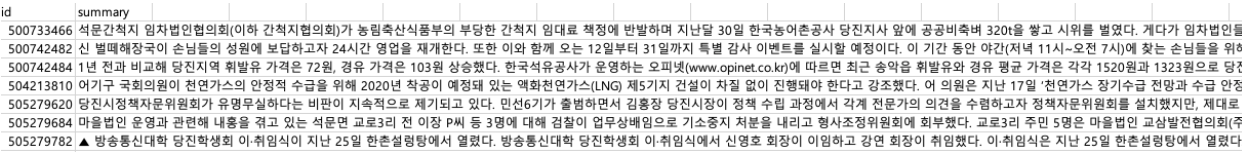